## Plot network localization over a grid on the sky

In [1]:
import numpy as np
import pylab as plt

from pycbc import psd, detector
from pycbc.cosmology import redshift
from simple_pe.localization import Event
from simple_pe.detectors import Network
import cartopy.crs as ccrs

import configurations

Network details

In [2]:
networks = configurations.generate_networks()

Set up a grid of trials and localize

In [3]:
# set up trials
dra, ddec = np.pi/8.0, np.pi/16.0
[ra,dec] = np.mgrid[-np.pi + dra/2: np.pi + dra/2: dra, -np.pi/2 + ddec: np.pi/2: ddec]

ra_grid = ra.flatten()
dec_grid = dec.flatten()
psi = 0.
cosi = 1.
gps = float(999995380)

In [4]:
dl = 1200.
z = redshift(dl)
mass = 1.4
m1 = m2 = mass * (1 + z)

In [5]:
ntrials = len(ra)

params = {}
params['distance'] = dl
params['gps'] = gps
params['coa-phase'] = 0.
params['polarization'] = psi
params['inclination'] = np.arccos(cosi)
params['mass1'] = m1
params['mass2'] = m2
params['RAdeg'] = 0.
params['DEdeg'] = 0.

In [6]:
num_found, num_loc, all_events = {}, {}, {}

for name, net in networks.items():
    
    nf, nl = 0, 0
    all_events[name] = []
    for trial, r in enumerate(ra_grid):
        params['RAdeg'] = np.degrees(r)
        params['DEdeg'] = np.degrees(dec_grid[trial])
        event = Event.from_params(params)
        event.add_network(net)
        all_events[name].append(event)
        if event.detected:
            nf += 1
            if event.localized >= 3:
                nl += 1
                event.localize_all(methods=['coh'])        

/mnt/c/Users/spxsf2/Code/simple-pe/simple_pe/localization/loc.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma = 1 / np.sqrt(ev + epsilon)
/mnt/c/Users/spxsf2/Code/simple-pe/simple_pe/localization/loc.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  self.like += np.log(32. * (self.D / d_max) ** 3 * self.D ** 4 / (Fp ** 2 * Fc ** 2)


Make plots

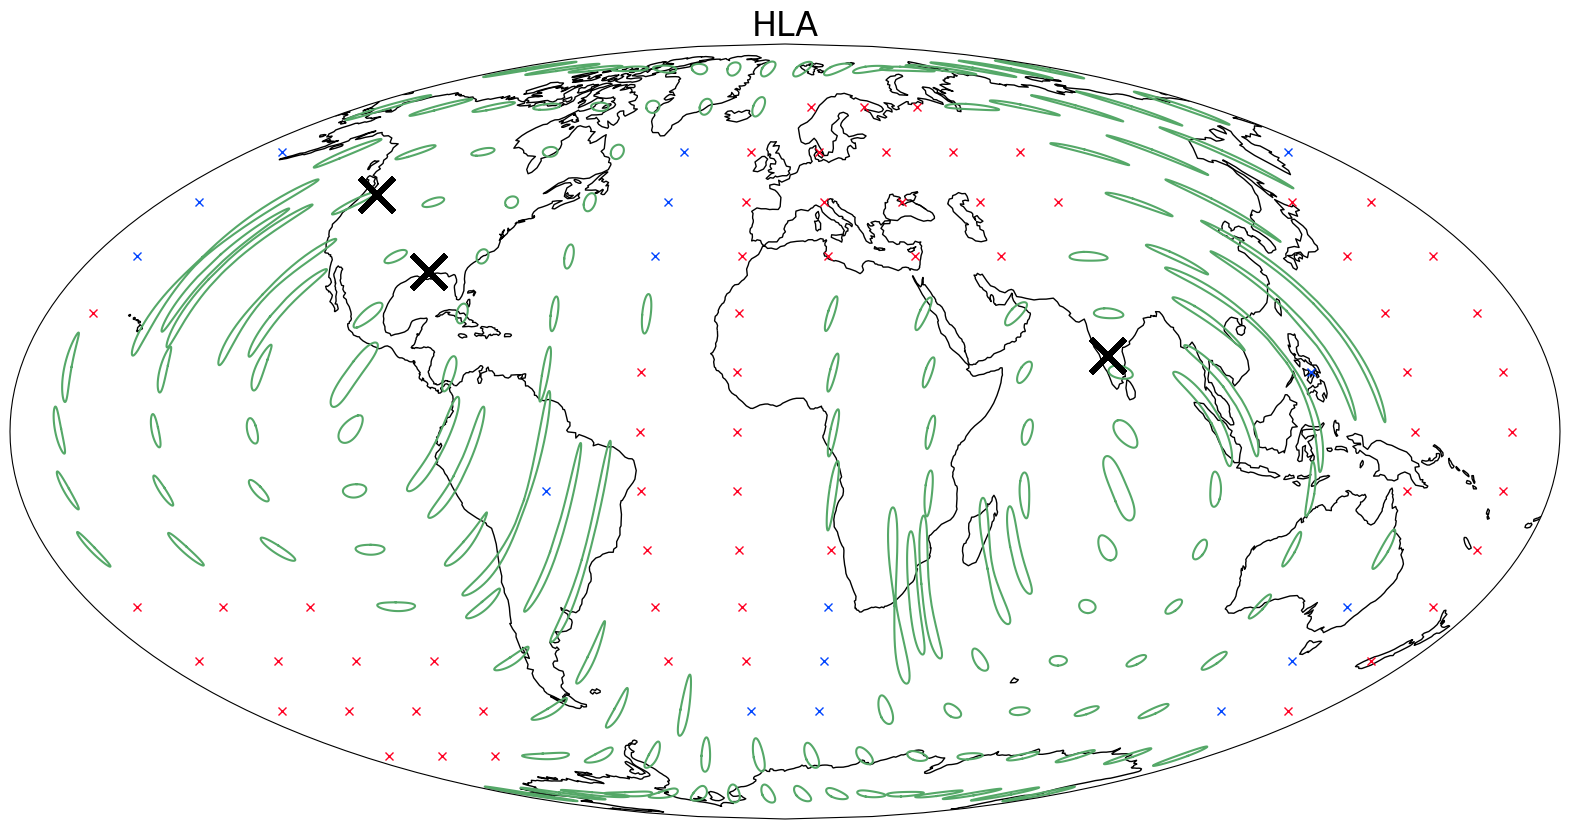

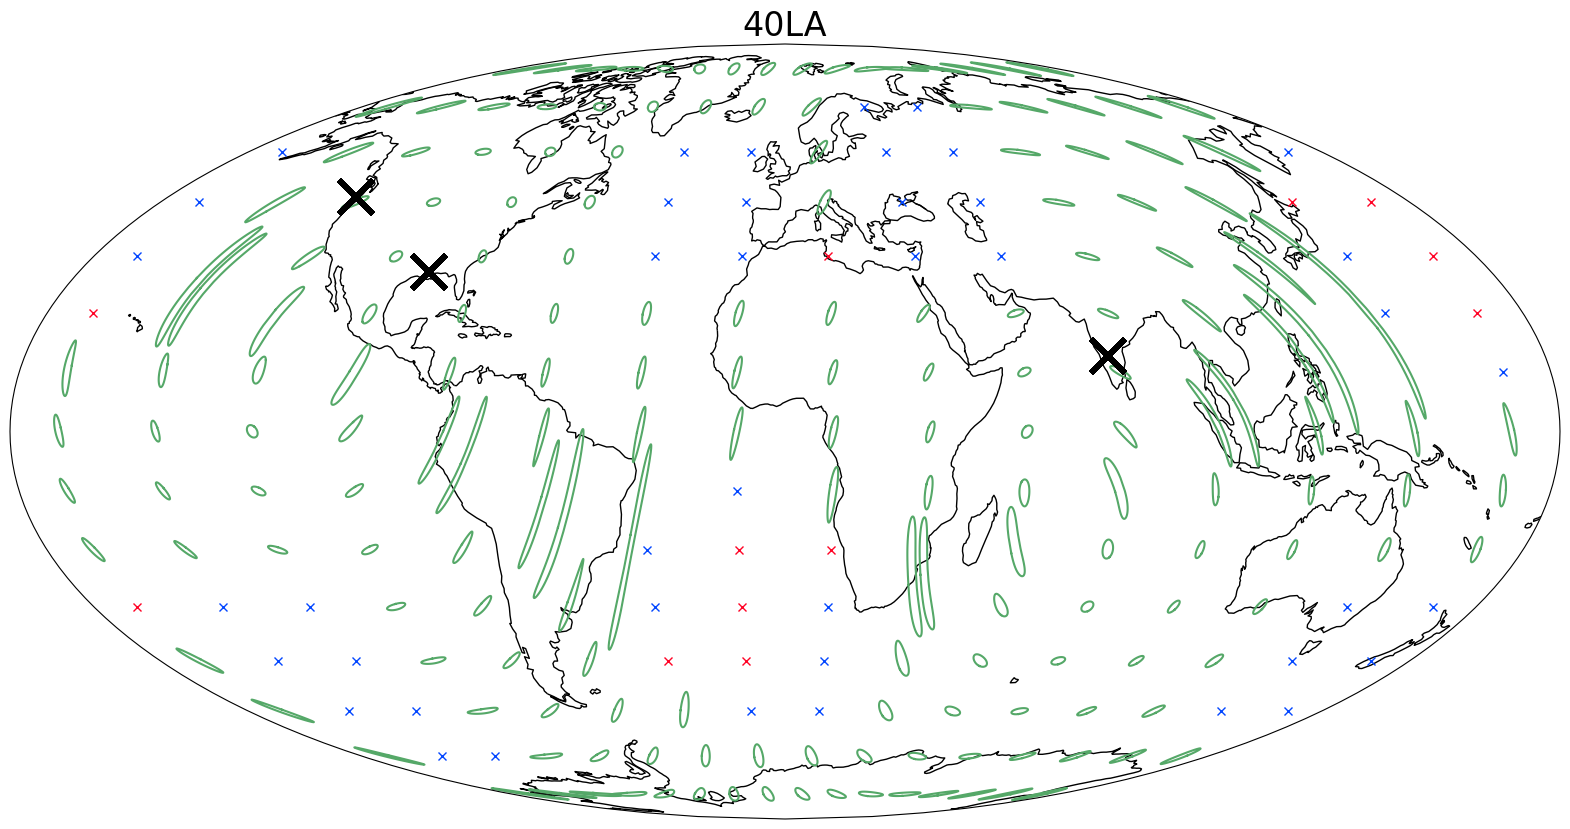

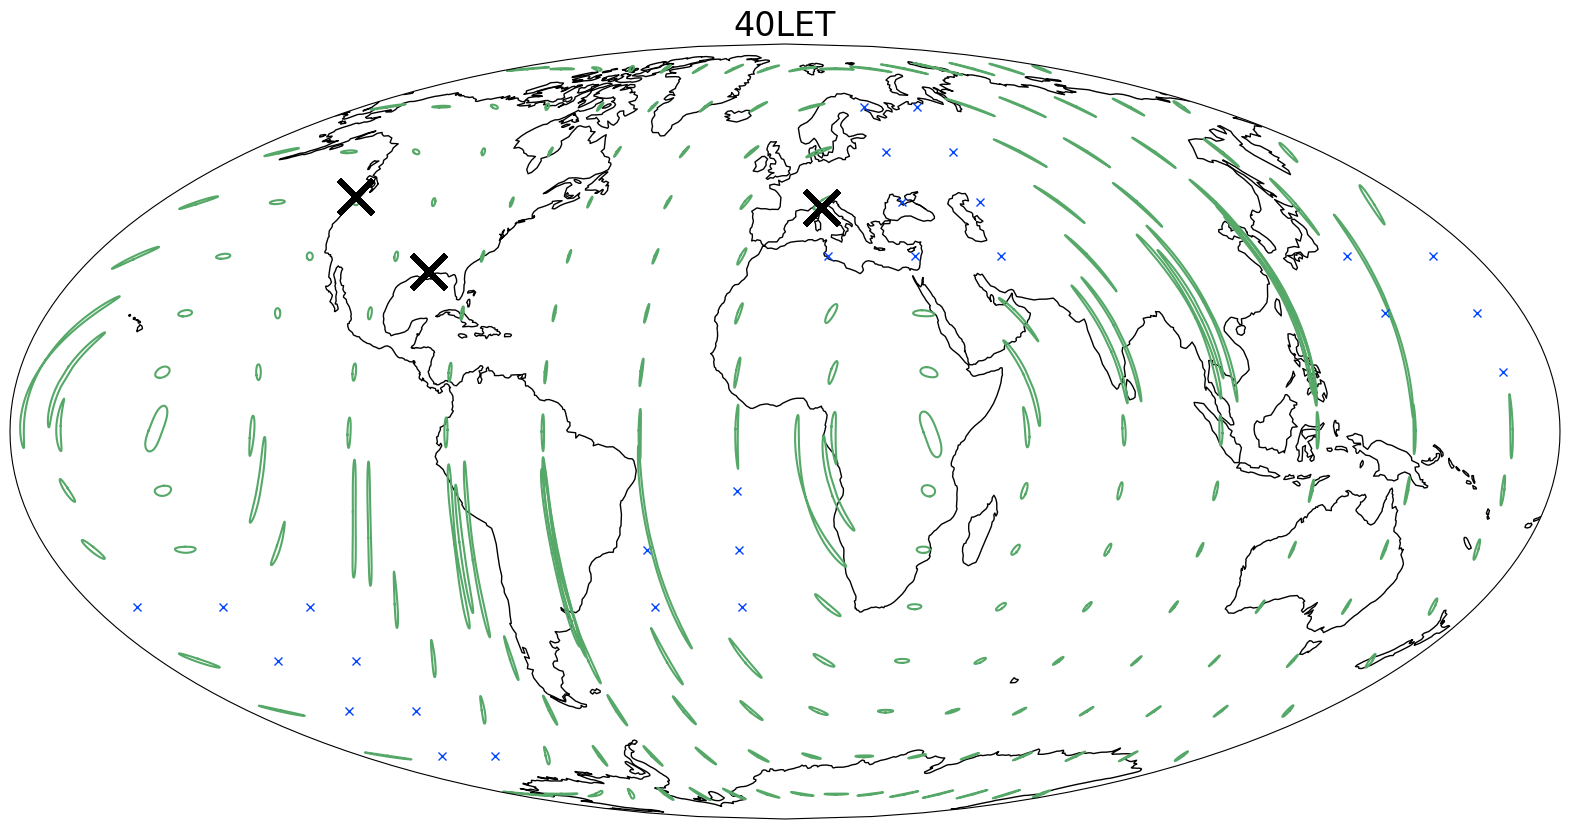

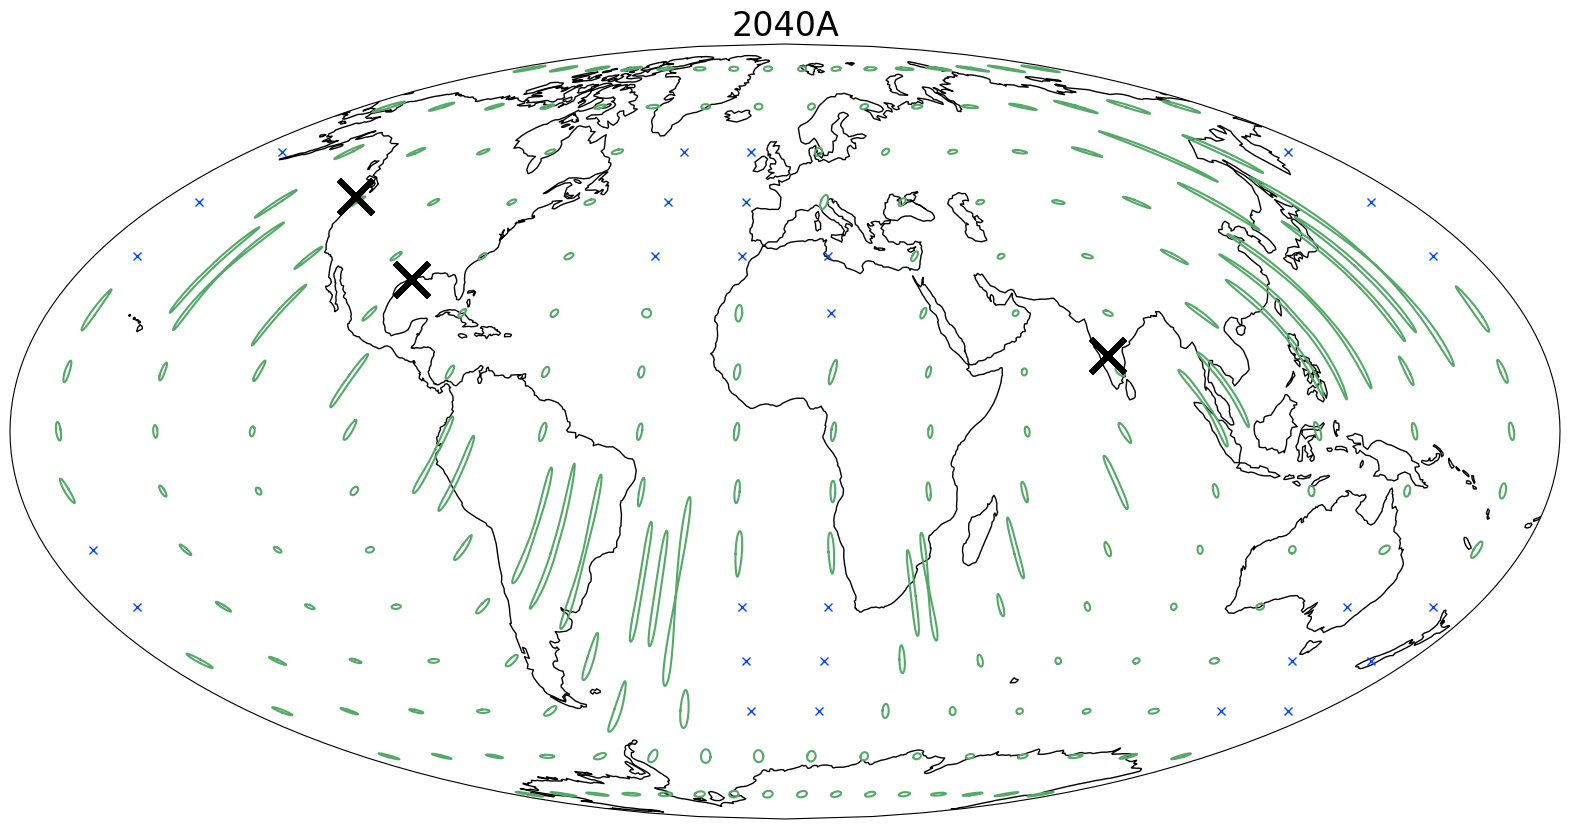

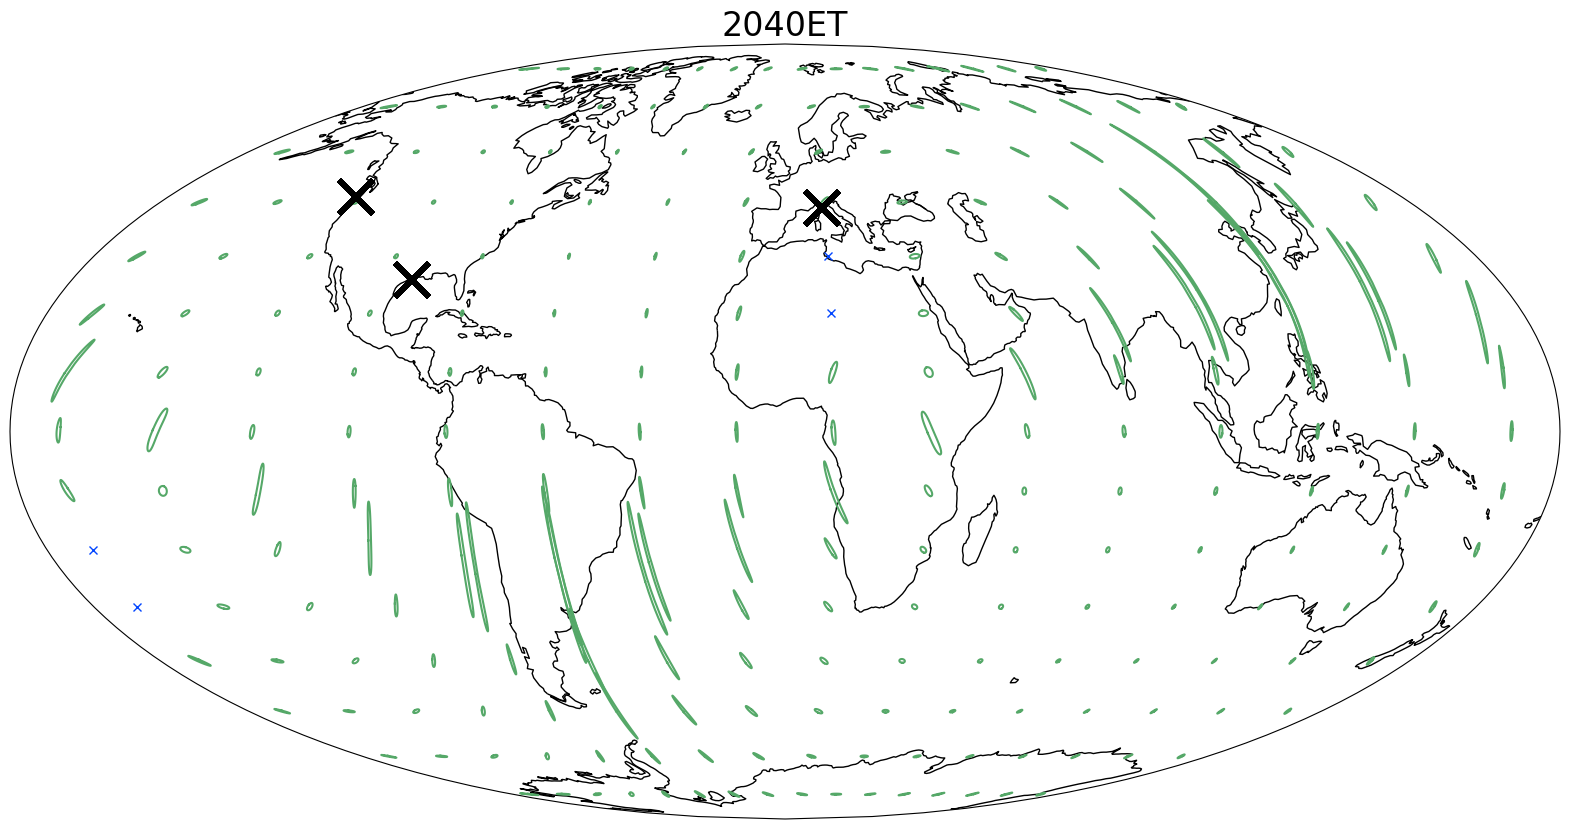

In [7]:
for name, net in networks.items():

    plt.figure(figsize=[20,20])
    ax = plt.axes(projection=ccrs.Mollweide())
    data_crs = ccrs.PlateCarree()
    ax.coastlines()

    for i, ev in enumerate(all_events[name]):
        if not ev.detected:
            ra = (ev.ra - ev.gmst) % (2*np.pi)
            ax.plot(np.degrees(ev.ra - ev.gmst), np.degrees(ev.dec) ,'#ff0325', marker = 'x', 
                    markersize=6, markeredgewidth=1, transform=data_crs)
        elif (ev.localized < 3):
            ra = (ev.ra - ev.gmst) % (2*np.pi)
            ax.plot(np.degrees(ev.ra - ev.gmst), np.degrees(ev.dec) ,'#0346ff', marker = 'x', 
                    markersize=6, markeredgewidth=1, transform=data_crs)
        else:
            phi, theta = ev.localization['coh'].make_ellipse()
            ax.plot(np.degrees((phi - np.pi) % (2 * np.pi) + np.pi), np.degrees(theta), 'g', transform=data_crs)

        for ifo in ev.ifos:
            i = ev.__getattribute__(ifo)
            ax.plot(np.degrees(i.longitude), np.degrees(i.latitude), marker='x', markersize=25, 
                    markerfacecolor='w', markeredgecolor='k', markeredgewidth=4, 
                    transform=data_crs)

    plt.title(name, fontsize = 24)
    plt.savefig('figures/Localization_ellipses_BNS_z_%s_%s.png' % (str(round(z,1)).replace('.', '_'), name) )